# Single-Cell Expression Demo

* Dataset: [GSE134809](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE134809)
* Paper: Martin et al. ["Single-Cell Analysis of Crohn’s Disease Lesions Identifies a Pathogenic Cellular Module Associated with Resistance to Anti-TNF Therapy"](https://www.sciencedirect.com/science/article/pii/S0092867419308967), 2019.
* Size: 82,417 lamina propria cells from 22 paired inflamed and uninflamed ileum tissues of 11 iCD patients

### 1. Connect to the instance

In [1]:
library(integrationCurator)
suppressMessages(library(tidyverse))

Sys.setenv(PRED_SPOT_HOST='odm-dev.genestack.com',PRED_SPOT_TOKEN='tknRoot',PRED_SPOT_VERSION='default-released')
page_limit = 2000

### 2. Query tissue metadata (for inflamed ileum tissues from GIMATS+/GIMATS- patients)

In [2]:
study_filter = sprintf('"%s"="%s"', 'genestack:accession', 'GSF167149')

tissue_filter = sprintf('"%s"="%s"', 'status.ch1', 'Involved')
patient_filter_pos = sprintf('"%s"="%s"', 'Patient Status', 'GIMATS+')
patient_filter_neg = sprintf('"%s"="%s"', 'Patient Status', 'GIMATS-')
sample_filter = sprintf('%s AND (%s OR %s)', tissue_filter, patient_filter_pos, patient_filter_neg)

start = Sys.time()
samples <- as_tibble(integrationCurator::OmicsQueriesApi_search_samples(
    study_filter=study_filter,
    sample_filter=sample_filter,
    page_limit=page_limit
)$content$data[['metadata']])
samples = samples[, c('genestack:accession','Sample Source ID','Patient ID','Patient Status','status.ch1')]

cat(sprintf('Time to get %s samples: %s seconds\n\n', nrow(samples), round(Sys.time()-start)))
print(samples)

Time to get 9 samples: 2 seconds

# A tibble: 9 x 5
  `genestack:accessi… `Sample Source I… `Patient ID` `Patient Status` status.ch1
  <chr>               <chr>             <chr>        <chr>            <chr>     
1 GSF167166           190               13           GIMATS-          Involved  
2 GSF167164           187               12           GIMATS+          Involved  
3 GSF167155           128               7            GIMATS+          Involved  
4 GSF167170           196               15           GIMATS-          Involved  
5 GSF167152           69                5            GIMATS+          Involved  
6 GSF167168           193               14           GIMATS-          Involved  
7 GSF167159           158               10           GIMATS-          Involved  
8 GSF167158           138               8            GIMATS+          Involved  
9 GSF167162           181               11           GIMATS+          Involved  


### 3. Query expression values (for gene TNF)

In [3]:
gene = 'TNF'
expression_filter = sprintf('Gene=%s MinValue=0', gene)

start = Sys.time()
expressions = as_tibble(do.call(cbind, OmicsQueriesApi_search_expression_data(
    study_filter = study_filter,
    sample_filter = sample_filter,
    ex_query = expression_filter,
    page_limit = page_limit
)$content$data))

cat(sprintf('Time to get %s expression values: %s seconds\n\n', 
    nrow(expressions), round(Sys.time()-start)))
print(expressions)

Time to get 1791 expression values: 14 seconds

# A tibble: 1,791 x 8
   itemId `Run Source ID` runId groupId gene  expression relationships.s…
   <fct>  <chr>           <fct> <fct>   <fct>      <dbl> <chr>           
 1 GSF17… 69_69-AAGTATAC… GSF1… GSF167… TNF            1 GSF167152       
 2 GSF17… 69_69-AAGTGCAC… GSF1… GSF167… TNF            1 GSF167152       
 3 GSF17… 69_69-AATCAAAC… GSF1… GSF167… TNF            1 GSF167152       
 4 GSF17… 69_69-ACAACCGA… GSF1… GSF167… TNF            1 GSF167152       
 5 GSF17… 69_69-ACGGATTG… GSF1… GSF167… TNF            1 GSF167152       
 6 GSF17… 69_69-ACTCCCGA… GSF1… GSF167… TNF            1 GSF167152       
 7 GSF17… 69_69-ACTCTATG… GSF1… GSF167… TNF            1 GSF167152       
 8 GSF17… 69_69-ACTTGTAC… GSF1… GSF167… TNF            3 GSF167152       
 9 GSF17… 69_69-ACTTTGTG… GSF1… GSF167… TNF            1 GSF167152       
10 GSF17… 69_69-AGACTCGA… GSF1… GSF167… TNF            3 GSF167152       
# … with 1,781 more rows, and 1 more varia

### 4. Get external cell-level metadata

In [4]:
cell_metadata = read_tsv('https://bio-test-data.s3.amazonaws.com/GSE134809/cell_metadata_GSE134809.tsv',
                         col_types = cols(.default = "c"))
cell_metadata = cell_metadata %>% unite('cell', Lane:Barcode)

expressions = inner_join(expressions, cell_metadata, by=c('Run Source ID'='cell'))
expressions = inner_join(expressions, samples, by=c('relationships.sample'='genestack:accession'))
print(expressions)

# A tibble: 1,786 x 15
   itemId `Run Source ID` runId groupId gene  expression relationships.s…
   <fct>  <chr>           <fct> <fct>   <fct>      <dbl> <chr>           
 1 GSF17… 69_69-AAGTATAC… GSF1… GSF167… TNF            1 GSF167152       
 2 GSF17… 69_69-AAGTGCAC… GSF1… GSF167… TNF            1 GSF167152       
 3 GSF17… 69_69-AATCAAAC… GSF1… GSF167… TNF            1 GSF167152       
 4 GSF17… 69_69-ACAACCGA… GSF1… GSF167… TNF            1 GSF167152       
 5 GSF17… 69_69-ACGGATTG… GSF1… GSF167… TNF            1 GSF167152       
 6 GSF17… 69_69-ACTCCCGA… GSF1… GSF167… TNF            1 GSF167152       
 7 GSF17… 69_69-ACTCTATG… GSF1… GSF167… TNF            1 GSF167152       
 8 GSF17… 69_69-ACTTGTAC… GSF1… GSF167… TNF            3 GSF167152       
 9 GSF17… 69_69-ACTTTGTG… GSF1… GSF167… TNF            1 GSF167152       
10 GSF17… 69_69-AGACTCGA… GSF1… GSF167… TNF            3 GSF167152       
# … with 1,776 more rows, and 8 more variables: relationships.cell <chr>,
#   Type <chr>,

### 5. Compare TNF expression across cell types, between GIMATS+ vs GIMATS- patients
It is interesting that TNF was produced mainly by T cells in patients with low GIMATS module scores, while it was produced both by T cells and infl. MNPs in patients with a high module scores.

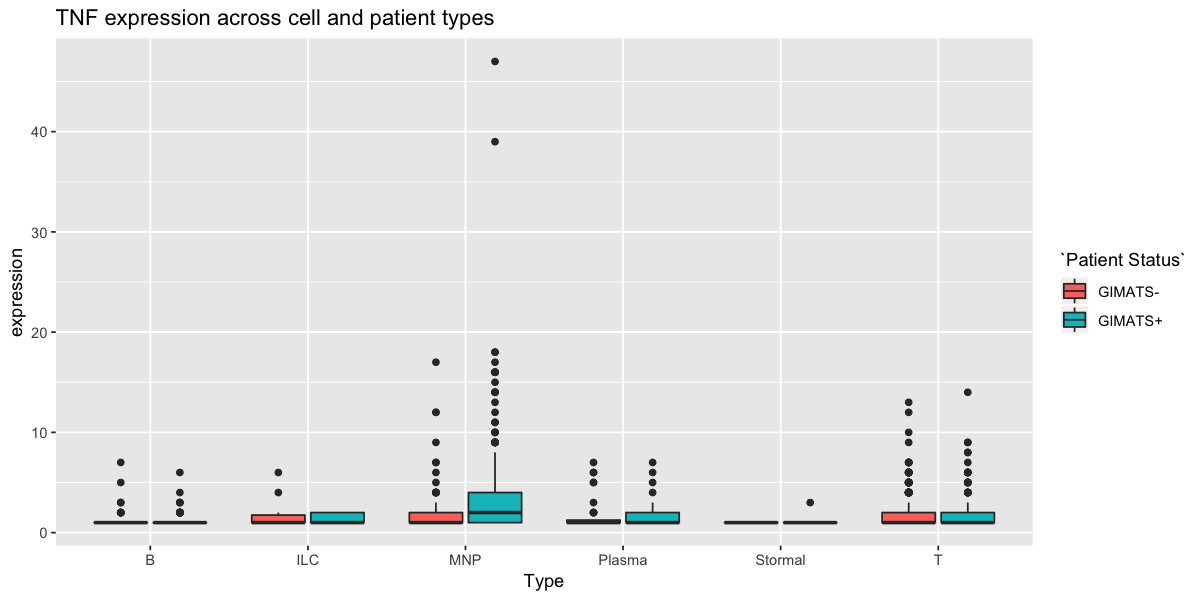

In [5]:
library(repr)
options(repr.plot.width=10, repr.plot.height=5)
ggplot(expressions, 
    mapping=aes(x=`Type`, y=expression, fill=`Patient Status`)) + 
    geom_boxplot() + ggtitle(sprintf('%s expression across cell and patient types', gene))